# Load a model and check its scores on the test set

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import label_binarize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
import text_package

HAM = 'ham'
SPAM = 'spam'
SUBJECT = 'Subject'
CONTENT = 'Content'
BOTH = 'Both'
CLASS = 'Class'
ACCURACY = 'Accuracy'
PRECISION = 'Precision'
RECALL = 'recall'
F1 = 'f1'

# Get the train and test data sets
train_list = text_package.get_text_from_csv('train.csv')
test_list = text_package.get_text_from_csv('test.csv')
# Create the vectorizer
simple_vectorizer = CountVectorizer()
# Make sure the data samples are normalized
vector = simple_vectorizer.fit_transform(train_list[CONTENT].values)
transformed = simple_vectorizer.transform(test_list[CONTENT].values)
# Get the labels as well
labels = simple_vectorizer.transform(test_list[CLASS].values)

# Load the best accuracy combination of model and feature
model = pickle.load(open('nb_content.sav', 'rb'))

# Make predictions with the test set
predictions = model.predict(transformed)

# Print the 4 scores obtained from the prediction of the test sets
print('Accuracy:  ', metrics.accuracy_score(test_list[CLASS].values, predictions))
print('Precision: ', metrics.precision_score(test_list[CLASS].values, predictions, average='weighted'))
print('Recall:    ', metrics.recall_score(test_list[CLASS].values, predictions, average='weighted'))
print('F1:        ', metrics.f1_score(test_list[CLASS].values, predictions, average='weighted'))

Accuracy:   0.986534582987
Precision:  0.986535085521
Recall:     0.986534582987
F1:         0.986534414058


# Compute the AUC metric

In [2]:
# Get the scores of each prediction
y_score = model.predict_proba(transformed)
# Binarize the labels (use a little tweak to keep a 2-dimensional array and not only one (cause by binary labelling))
labels_b = label_binarize(test_list[CLASS].values, classes=[HAM, SPAM, '0'])
labels_b_del = np.delete(labels_b, 2, axis=1)
n_classes = labels_b_del.shape[1]
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = metrics.roc_curve(labels_b_del[:, i], y_score[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

# Compute ROC curve and ROC area for each class
fpr["micro"], tpr["micro"], _ = metrics.roc_curve(labels_b_del.ravel(), y_score.ravel())
roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])

print(roc_auc)

{0: 0.99759469918067145, 1: 0.99744599322066396, 'micro': 0.99757443919178568}


# Make a ROC plot of each class for the loaded model

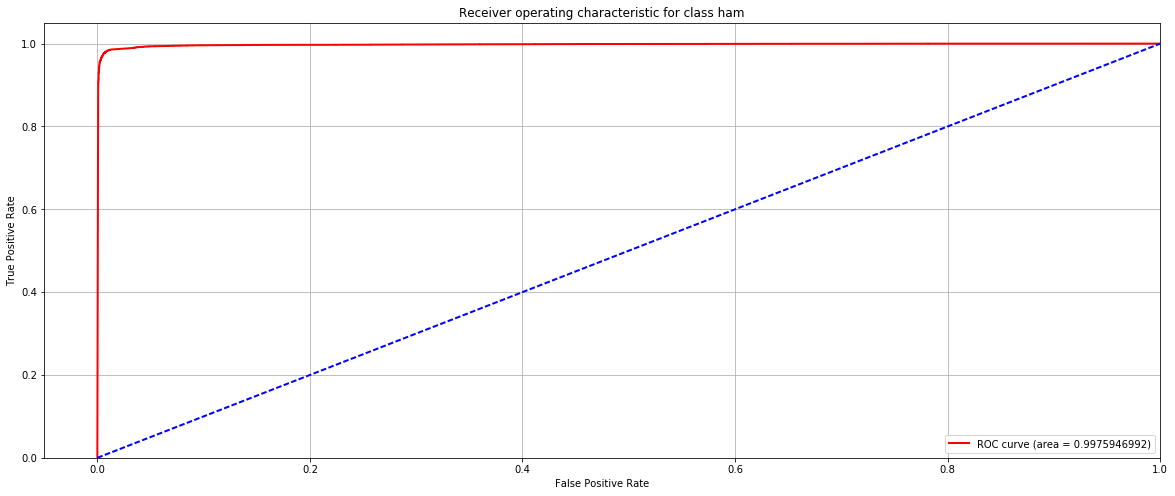

In [3]:
# Make a ROC plot using the ROC curve, for any class
def plot_roc(class_plot, n_class):
    plt.figure(figsize=(20, 8))
    # Print the area (which is auc) as the legend
    plt.plot(fpr[n_class], tpr[n_class], color='r',
             lw=2, label='ROC curve (area = %0.10f)' % roc_auc[n_class])
    plt.plot([0, 1], [0, 1], color='b', lw=2, linestyle='--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for class '+class_plot)
    plt.legend(loc="lower right")
    plt.grid(True)
    
    return plt

# Plot it for the ham class
plot_roc(HAM, 0).show()

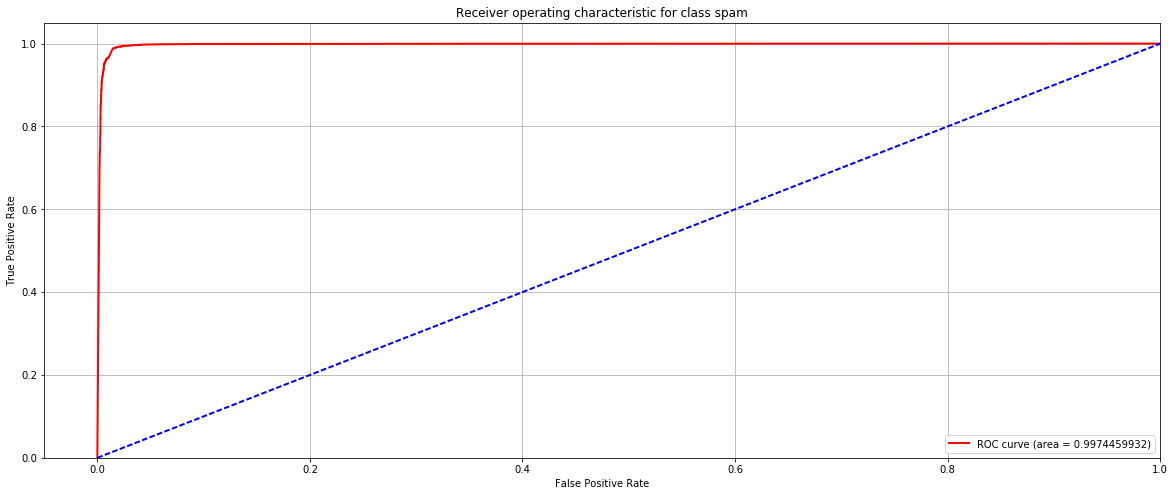

In [4]:
# And for the spam class
plot_roc(SPAM, 1).show()

In [5]:
# Get the confusion matrix between the expected and predicted values
conf_mat = metrics.confusion_matrix(test_list[CLASS].values, predictions, labels=[HAM, SPAM])
print(conf_mat)

[[16307   238]
 [  216 16955]]


In [6]:
# Print the matrix as normalized
conf_mat_norm = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
print(conf_mat_norm)

[[ 0.98561499  0.01438501]
 [ 0.01257935  0.98742065]]


# Plot the confusion matrix of the model

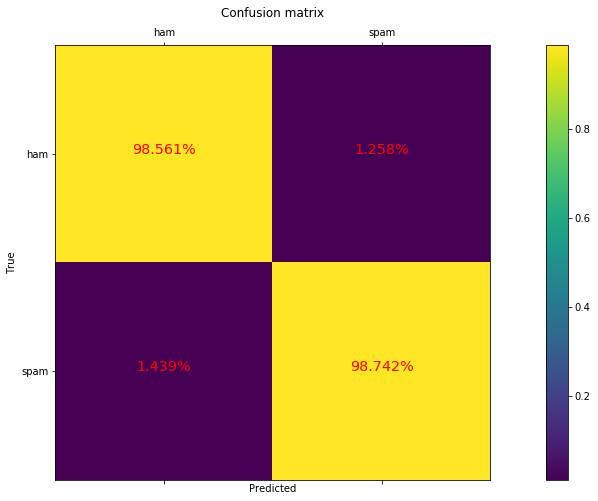

In [7]:
# Plot the confusion matrix using a color bar
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat_norm)
plt.title('Confusion matrix')
bar = fig.colorbar(cax)
ax.set_xticklabels([''] + [HAM, SPAM])
ax.set_yticklabels([''] + [HAM, SPAM])
mat = conf_mat_norm.flatten()
ax.text(0, 0, "{0:5.3%}".format(mat[0]), horizontalalignment='center', color='red', size='x-large')
ax.text(0, 1, "{0:5.3%}".format(mat[1]), horizontalalignment='center', color='red', size='x-large')
ax.text(1, 0, "{0:5.3%}".format(mat[2]), horizontalalignment='center', color='red', size='x-large')
ax.text(1, 1, "{0:5.3%}".format(mat[3]), horizontalalignment='center', color='red', size='x-large')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()